In [300]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import make_scorer, mean_squared_error, r2_score, matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, train_test_split

In [301]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

import src.evaluate_regression as er
import src.load_datasets as ld

from src.encoding import ohe_encode_train_data
from src.meta_information import add_dataset_meta_information
from src.feature_engineering import normalize_train_data
from src.data_cleaning import drop_pearson_correlated_features

In [302]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_style("whitegrid")
sns.set_palette("Set2") # Paired

In [303]:
random_state = 42

# Load data

In [304]:
DATA_DIR = Path("./data")

In [305]:
df_train = ld.load_dataset("../../data/raw/dataset_rank_train.csv")
if "cv_score" in df_train.columns:
    df_train = df_train.drop("cv_score", axis=1)

Loading data from '../../data/raw/dataset_rank_train.csv' ...


In [306]:
print("Shape of train data: ", df_train.shape)
print("Columns of train data: ", df_train.columns)
#df_train.sort_values(by=["dataset", "rank"], inplace=True)
df_train.head()

Shape of train data:  (36054, 6)
Columns of train data:  Index(['dataset', 'model', 'tuning', 'scoring', 'encoder', 'rank'], dtype='object')


,dataset,model,tuning,scoring,encoder,rank
0,1169,KNC,model,ACC,BUCV2RGLMME,16.0
1,1169,KNC,model,ACC,BUCV2TE,14.0
2,1169,KNC,model,ACC,CBE,22.0
3,1169,KNC,model,ACC,CE,23.0
4,1169,KNC,model,ACC,CV10RGLMME,7.0


# Pivot data to get multi-output target of encoder ranking

In [307]:
# statics of rank
factors = ["dataset", "model", "tuning", "scoring"]
new_index = "encoder"
target = "rank"

In [308]:
# pivot encoder column with rank as value
df_train_pivot = df_train.pivot_table(
    index=factors, columns=new_index, values=target, aggfunc="first"
).reset_index()

In [309]:
print("Shape of train data: ", df_train_pivot.shape)
print("Columns of train data: ", df_train_pivot.columns)
df_train_pivot.head()

Shape of train data:  (1161, 36)
Columns of train data:  Index(['dataset', 'model', 'tuning', 'scoring', 'BE', 'BUCV10RGLMME',
       'BUCV10TE', 'BUCV2RGLMME', 'BUCV2TE', 'BUCV5RGLMME', 'BUCV5TE', 'CBE',
       'CE', 'CV10RGLMME', 'CV10TE', 'CV2RGLMME', 'CV2TE', 'CV5RGLMME',
       'CV5TE', 'DE', 'DTEM10', 'DTEM2', 'DTEM5', 'ME01E', 'ME10E', 'ME1E',
       'MHE', 'OE', 'OHE', 'PBTE0001', 'PBTE001', 'PBTE01', 'RGLMME', 'SE',
       'TE', 'WOEE'],
      dtype='object', name='encoder')


encoder,dataset,model,tuning,scoring,BE,BUCV10RGLMME,BUCV10TE,BUCV2RGLMME,BUCV2TE,BUCV5RGLMME,...,MHE,OE,OHE,PBTE0001,PBTE001,PBTE01,RGLMME,SE,TE,WOEE
0,3,DTC,full,ACC,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
1,3,DTC,full,AUC,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
2,3,DTC,full,F1,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
3,3,DTC,model,AUC,12.0,14.0,0.0,18.0,6.0,17.0,...,2.0,9.0,5.0,7.0,11.0,23.0,19.0,1.0,3.0,3.0
4,3,DTC,model,F1,12.0,13.0,0.0,18.0,6.0,16.0,...,2.0,9.0,5.0,7.0,11.0,23.0,19.0,1.0,3.0,3.0


In [310]:
# Set train variables
X_train = df_train_pivot[factors]
y_train = df_train_pivot.drop(factors, axis=1)
# Update target
target = y_train.columns.tolist()

In [311]:
# Check for missing values
print("Missing values in train data: ", X_train.isnull().sum().sum())
print("Missing values in target: ", y_train.isnull().sum().sum())

Missing values in train data:  0
Missing values in target:  1098


In [312]:
# Fill missing values (or np.max() of target)
y_train.fillna(y_train.median(), inplace=True)

In [313]:
# Check for missing values
print("Missing values in train data: ", X_train.isnull().sum().sum())
print("Missing values in target: ", y_train.isnull().sum().sum())

Missing values in train data:  0
Missing values in target:  0


# Preprocess data

In [314]:
# Save copy of unprocessed train data
X_train_original = X_train.copy()

In [315]:
%%time
# Encode categorical features
X_train, _ = ohe_encode_train_data(X_train=X_train, cols_to_encode=["model", "tuning", "scoring"], verbosity=1)
# Add meta information
X_train = add_dataset_meta_information(df=X_train,
                                        path_to_meta_df="../../data/preprocessed/dataset_agg.csv",
                                        nan_threshold=0.5,
                                        replacing_strategy="median")
# Drop correlated features
X_train, _ = drop_pearson_correlated_features(train_data=X_train, test_data=None, threshold=0.7, verbosity=1)
# Normalize
X_train, scaler = normalize_train_data(X_train=X_train, method="minmax", verbosity=1)

One Hot Encoding the features ['model', 'tuning', 'scoring'] of the train data ...
Drop pearson correlated features with threshold 0.7...
Filter correlated features
Normalizing train data using method 'minmax' ...
CPU times: total: 93.8 ms
Wall time: 240 ms


In [316]:
print("Shape of train data: ", X_train.shape)
print("Columns of train data: ", X_train.columns)
X_train.head()

Shape of train data:  (1161, 40)
Columns of train data:  Index(['dataset', 'model_DTC', 'model_KNC', 'model_LGBMC', 'model_LR',
       'model_SVC', 'tuning_full', 'tuning_model', 'tuning_no', 'scoring_ACC',
       'scoring_AUC', 'scoring_F1', 'Quartile1KurtosisOfNumericAtts',
       'J48.001.ErrRate', 'Dimensionality', 'Quartile2MutualInformation',
       'MinSkewnessOfNumericAtts', 'Quartile2AttributeEntropy',
       'MinorityClassSize', 'MajorityClassPercentage',
       'Quartile2StdDevOfNumericAtts', 'NumberOfBinaryFeatures',
       'Quartile1MutualInformation', 'Quartile1MeansOfNumericAtts',
       'MaxMutualInformation', 'AutoCorrelation', 'PercentageOfBinaryFeatures',
       'MinKurtosisOfNumericAtts', 'DecisionStumpErrRate',
       'PercentageOfNumericFeatures', 'NumberOfSymbolicFeatures',
       'MinMutualInformation', 'PercentageOfInstancesWithMissingValues',
       'MinNominalAttDistinctValues', 'NumberOfNumericFeatures',
       'rows_with_null_values_count', 'categorical_tar

,dataset,model_DTC,model_KNC,model_LGBMC,model_LR,model_SVC,tuning_full,tuning_model,tuning_no,scoring_ACC,...,NumberOfSymbolicFeatures,MinMutualInformation,PercentageOfInstancesWithMissingValues,MinNominalAttDistinctValues,NumberOfNumericFeatures,rows_with_null_values_count,categorical_target_variables_count,non_categorical_target_variables_count,categorical_target_values_sum,min_number_of_categories_per_cat_feature
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.270073,4.793819e-08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015152
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.270073,4.793819e-08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015152
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.270073,4.793819e-08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015152
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.270073,4.793819e-08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015152
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.270073,4.793819e-08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015152


# Train and Evaluate models

In [317]:
# Model selection for multi-class classification
models = {
    "Random Forest": RandomForestRegressor(random_state=random_state),
    "XGBoost": XGBRegressor(random_state=random_state),
    "MultiOutReg(LightGBM)": MultiOutputRegressor(LGBMRegressor(random_state=random_state)),
    "KNN": KNeighborsRegressor(),
    "MultiOutReg(CatBoost)": MultiOutputRegressor(CatBoostRegressor(random_state=random_state, silent=True)),
    "Decision Tree": DecisionTreeRegressor(random_state=random_state),
    "MultiOutReg(Gradient Boosting)": MultiOutputRegressor(GradientBoostingRegressor(random_state=random_state)),
    "ExtraTrees": ExtraTreesRegressor(random_state=random_state)
}

## via cross validation on train set with mse and r2

In [318]:
# Get indices of train data
cv_indices = er.custom_cross_validated_indices(pd.concat([X_train_original, y_train], axis=1), factors, target, n_splits=5, shuffle=True, random_state=random_state)

In [319]:
# Define scoring for CV
scoring = {
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

In [320]:
%%time
# Train and evaluate models
cv_results = []
for i, (model_name, model) in enumerate(models.items()):
    print("Training model: ", model_name, f"({i+1}/{len(models)})", "...")

    # MinMax scale target if necessary (for ExtraTreesRegressor)
    if model_name == "ExtraTrees":
        scaler = MinMaxScaler()
        y_scaled = scaler.fit_transform(y_train)
        y_train = pd.DataFrame(y_scaled, columns=y_train.columns)

    # Perform CV
    results = cross_validate(estimator=model, X=X_train, y=y_train, cv=cv_indices, scoring=scoring, return_train_score=True, error_score="raise")
    results["model"] = model_name
    cv_results.append(results)

    # Iterate through the provided scoring (list) in cv_results and print results
    for scorer in scoring:
        print(f"CV Training {scorer}: {round(results['train_' + scorer].mean(), 4)} "
              f"+/- {round(results['train_' + scorer].std(), 4)} ")
        print(f"CV Test {scorer}: {round(results['test_' + scorer].mean(), 4)} "
                f"+/- {round(results['test_' + scorer].std(), 4)}")
    print("")

Training model:  Random Forest (1/8) ...
CV Training neg_mean_squared_error: -2.7416 +/- 0.062 
CV Test neg_mean_squared_error: -19.5221 +/- 1.1633
CV Training r2: 0.9579 +/- 0.0009 
CV Test r2: 0.6983 +/- 0.0195

Training model:  XGBoost (2/8) ...
CV Training neg_mean_squared_error: -0.309 +/- 0.0149 
CV Test neg_mean_squared_error: -22.2463 +/- 1.2395
CV Training r2: 0.9952 +/- 0.0002 
CV Test r2: 0.6542 +/- 0.0203

Training model:  MultiOutReg(LightGBM) (3/8) ...
CV Training neg_mean_squared_error: -7.5564 +/- 0.1091 
CV Test neg_mean_squared_error: -24.0577 +/- 1.5113
CV Training r2: 0.8837 +/- 0.0019 
CV Test r2: 0.6289 +/- 0.0263

Training model:  KNN (4/8) ...
CV Training neg_mean_squared_error: -42.968 +/- 0.5997 
CV Test neg_mean_squared_error: -63.8062 +/- 1.8013
CV Training r2: 0.35 +/- 0.0061 
CV Test r2: 0.03 +/- 0.0276

Training model:  MultiOutReg(CatBoost) (5/8) ...
CV Training neg_mean_squared_error: -2.6359 +/- 0.0425 
CV Test neg_mean_squared_error: -20.9982 +/- 1.31

## via custom cross validation on train set with average spearmen

In [321]:
%%time
# Train and evaluate models
spearmen_cv_results = []
for i, (model_name, model) in enumerate(models.items()):
    print("Training model: ", model_name, f"({i+1}/{len(models)})", "...")

    # MinMax scale target if necessary (for ExtraTreesRegressor)
    if model_name == "ExtraTrees":
        scaler = MinMaxScaler()
        y_scaled = scaler.fit_transform(y_train)
        y_train = pd.DataFrame(y_scaled, columns=y_train.columns)

    # Perform Custom CV
    scores = []
    for i, fold in enumerate(cv_indices):
        X_train_original_cv = X_train_original.iloc[fold[1]]
        # Split into train and test set
        X_train_cv, y_train_cv = X_train.iloc[fold[0]], y_train.iloc[fold[0]]
        X_test_cv, y_test_cv = X_train.iloc[fold[1]], y_train.iloc[fold[1]]

        # Train model on train set
        model.fit(X_train_cv, y_train_cv)

        # Predict on holdout set
        y_test_pred = pd.DataFrame(model.predict(X_test_cv), columns=y_train_cv.columns, index=X_test_cv.index)


        # Evaluate predictions
        df_pred = pd.merge(pd.concat([X_train_original_cv, y_test_cv], axis=1).melt(id_vars=factors, value_name="rank").dropna(axis=0),
                           pd.concat([X_train_original_cv, y_test_pred], axis=1).melt(id_vars=factors, value_name="pred_rank").dropna(axis=0),
                           on=factors+["encoder"], how="left")

        # Get rankings
        rankings_holdout = er.get_rankings(df=df_pred, factors=factors, target="rank", new_index=new_index)
        rankings_holdout_pred = er.get_rankings(df=df_pred, factors=factors, target="pred_rank", new_index=new_index)

        # Custom average spearman
        avg_spearman  = er.average_spearman(rankings_holdout, rankings_holdout_pred)
        scores.append(avg_spearman)

    spearmen_cv_results.append({"model": model_name, "avg_spearman": scores})

    # Print results
    print(f"CV Average Spearman: {round(np.mean(scores), 4)} "
          f"+/- {round(np.std(scores), 4)} ")
    print("")

Training model:  Random Forest (1/8) ...
CV Average Spearman: 0.722 +/- 0.0184 

Training model:  XGBoost (2/8) ...
CV Average Spearman: 0.6717 +/- 0.0186 

Training model:  MultiOutReg(LightGBM) (3/8) ...
CV Average Spearman: 0.6483 +/- 0.0269 

Training model:  KNN (4/8) ...
CV Average Spearman: 0.2492 +/- 0.0137 

Training model:  MultiOutReg(CatBoost) (5/8) ...
CV Average Spearman: 0.6807 +/- 0.025 

Training model:  Decision Tree (6/8) ...
CV Average Spearman: 0.7322 +/- 0.0131 

Training model:  MultiOutReg(Gradient Boosting) (7/8) ...
CV Average Spearman: 0.5755 +/- 0.0323 

Training model:  ExtraTrees (8/8) ...
CV Average Spearman: 0.7416 +/- 0.0084 

CPU times: total: 8min 57s
Wall time: 5min 38s


## compare results in plots

In [322]:
df_cv_results = pd.DataFrame(cv_results)
df_cv_results = df_cv_results.apply(pd.Series.explode)
df_cv_results["fold"] = df_cv_results.index % 5 + 1
#df_cv_results.set_index("model", inplace=True)
df_cv_results

,fit_time,score_time,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2,model,fold
0,2.033349,0.015689,-19.927363,-2.76972,0.680045,0.957975,Random Forest,1
0,1.07327,0.011112,-18.568331,-2.760653,0.718129,0.95757,Random Forest,1
0,1.125209,0.015838,-19.827926,-2.750745,0.698367,0.957702,Random Forest,1
0,1.11904,0.031136,-21.312142,-2.622852,0.673137,0.959532,Random Forest,1
0,1.127429,0.015666,-17.974488,-2.803839,0.721653,0.956971,Random Forest,1
1,3.057989,0.015626,-22.965737,-0.29149,0.627581,0.995516,XGBoost,2
1,2.710253,0.019931,-21.773844,-0.293111,0.667631,0.995444,XGBoost,2
1,2.733948,0.015003,-21.947883,-0.325565,0.662626,0.99494,XGBoost,2
1,2.410524,0.015507,-24.122681,-0.309418,0.633163,0.995199,XGBoost,2
1,2.674712,0.01563,-20.421198,-0.325471,0.679924,0.994933,XGBoost,2


In [323]:
df_spearmen_cv_results = pd.DataFrame(spearmen_cv_results)
df_spearmen_cv_results = df_spearmen_cv_results.apply(pd.Series.explode)
df_spearmen_cv_results["fold"] = df_spearmen_cv_results.index % 5 + 1
#df_spearmen_cv_results.set_index("model", inplace=True)
df_spearmen_cv_results

,model,avg_spearman,fold
0,Random Forest,0.708734,1
0,Random Forest,0.743589,1
0,Random Forest,0.710762,1
0,Random Forest,0.7019,1
0,Random Forest,0.745013,1
1,XGBoost,0.648826,2
1,XGBoost,0.685638,2
1,XGBoost,0.665126,2
1,XGBoost,0.658896,2
1,XGBoost,0.699987,2


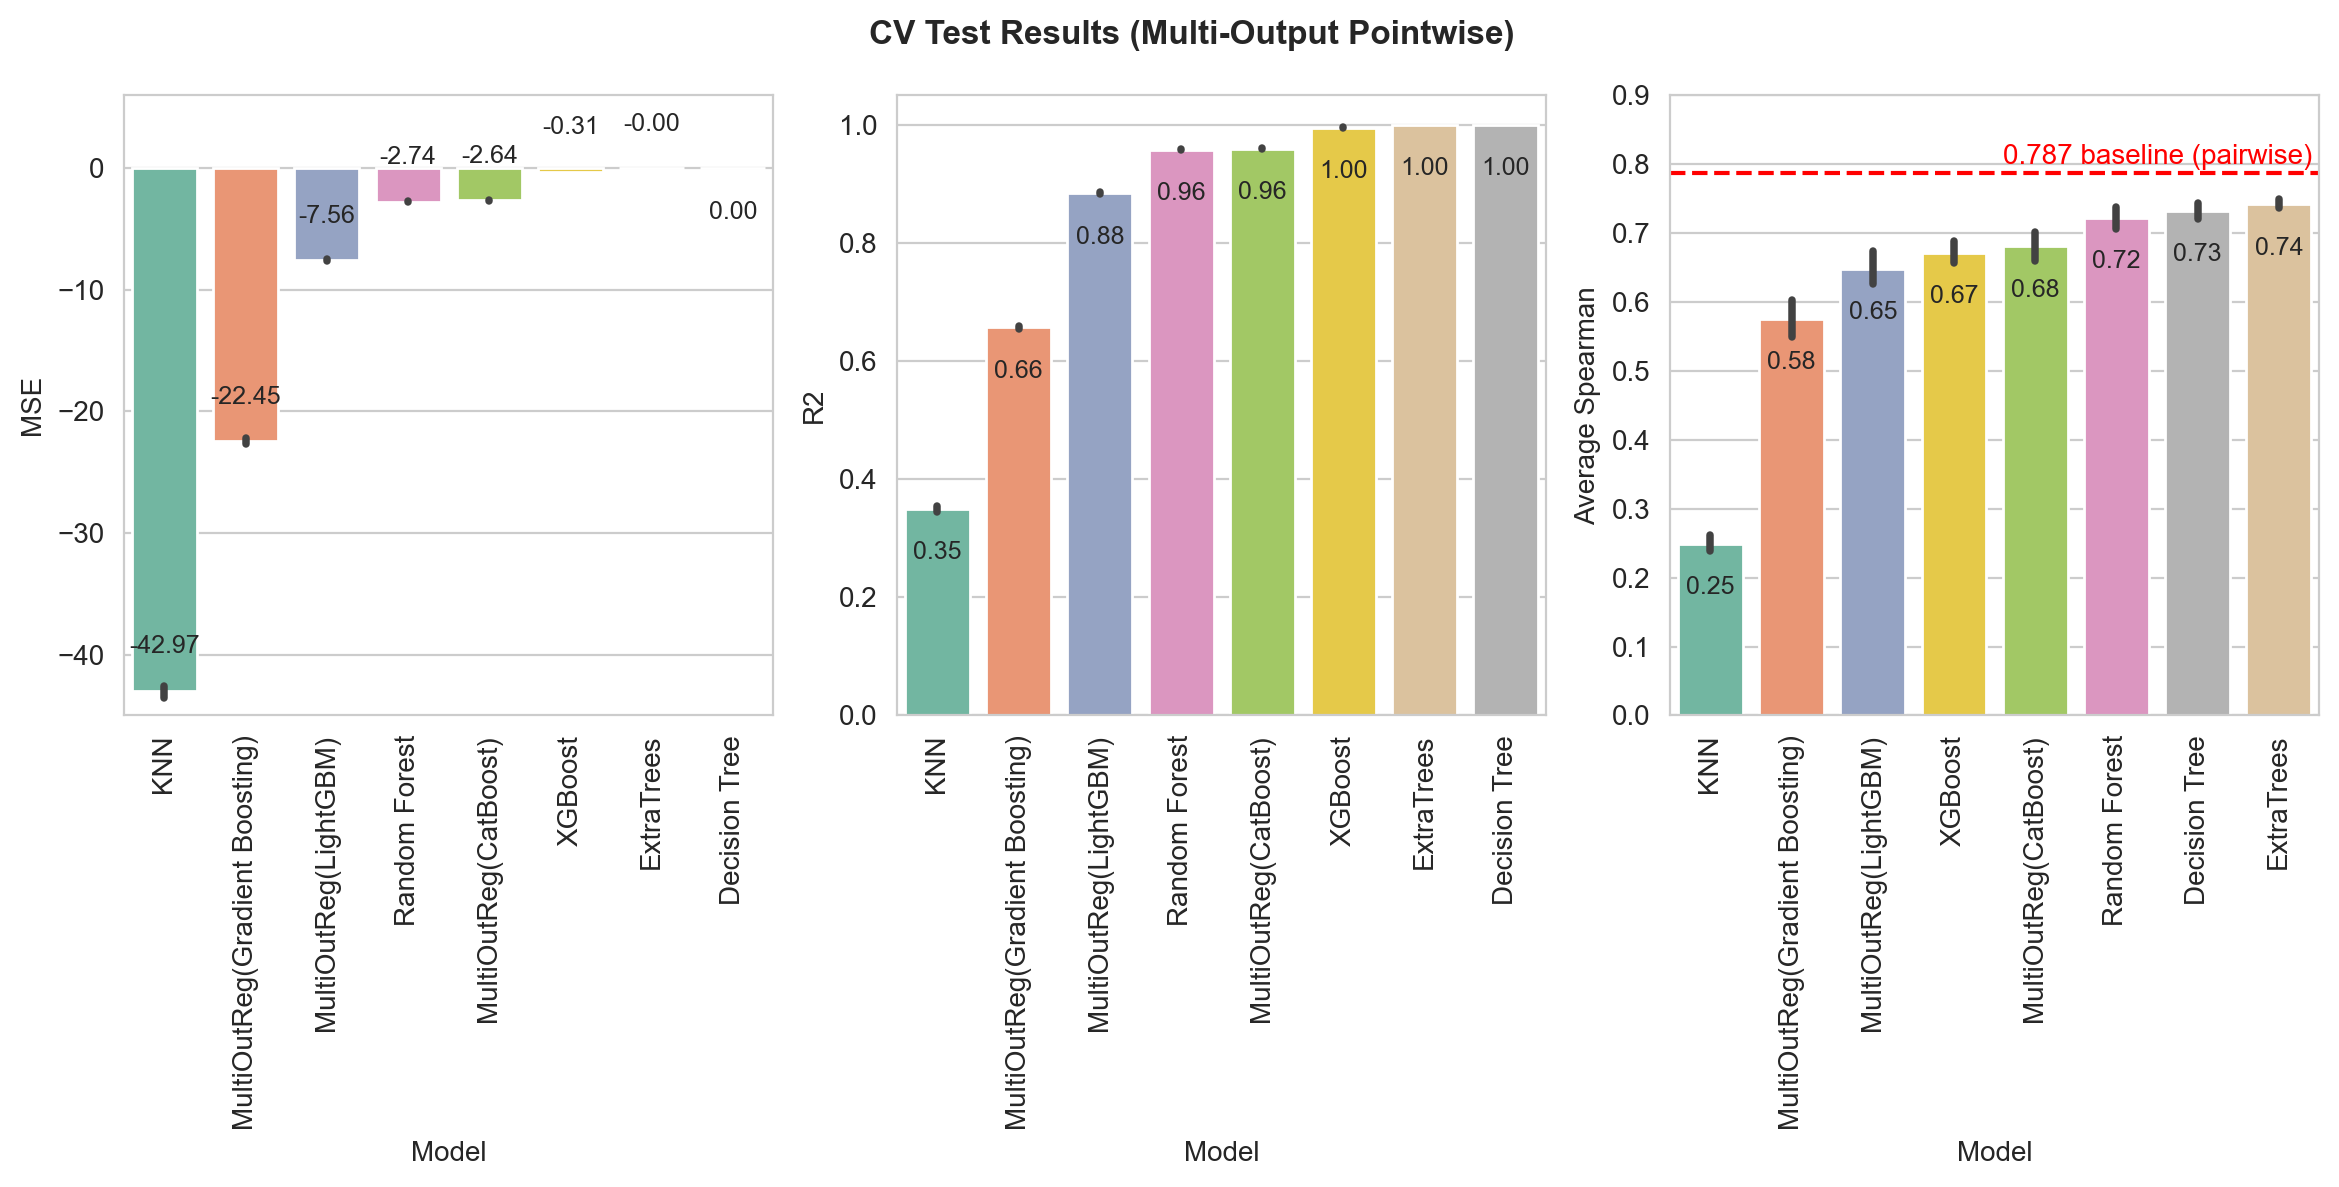

In [389]:
# Sort the DataFrame based on "train_neg_mean_squared_error" in ascending order
df_cv_results_sorted = df_cv_results.sort_values(by="train_neg_mean_squared_error")

# Map colors to models
colors = sns.color_palette("Set2", len(df_cv_results_sorted["model"].unique()))
color_map = {model: color for model, color in zip(df_cv_results_sorted["model"].unique(), colors)}

# Create the bar plots with the sorted DataFrame
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
fig.suptitle("CV Test Results (Multi-Output Pointwise)", fontweight="bold")

sns.barplot(data=df_cv_results_sorted, x="model", y="train_neg_mean_squared_error", ax=axes[0], palette=color_map)
axes[0].set_ylabel("MSE")
axes[0].bar_label(axes[0].containers[0], fmt='%.2f', padding=-20, fontsize=9)
axes[0].set_ylim(-45,6)

sns.barplot(data=df_cv_results_sorted, x="model", y="train_r2", ax=axes[1], palette=color_map)
axes[1].set_ylabel("R2")
axes[1].bar_label(axes[1].containers[0], fmt='%.2f', padding=-20, fontsize=9)

# Sort the DataFrame based on "avg_spearman" in ascending order
df_spearmen_cv_results_sorted = df_spearmen_cv_results.sort_values(by="avg_spearman")

sns.barplot(data=df_spearmen_cv_results_sorted, x="model", y="avg_spearman", ax=axes[2], palette=color_map)
axes[2].set_ylabel("Average Spearman")
axes[2].bar_label(axes[2].containers[0], fmt='%.2f', padding=-20, fontsize=9)
axes[2].set_ylim(0.0,0.9)
plt.axhline(y=0.787, color="red", linestyle="--", label="0.787 baseline (pairwise)")

for ax in axes:
    ax.set_xlabel("Model")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plot legend on top above the diagrams
plt.text(3.6, 0.8, '0.787 baseline (pairwise)', fontsize=10, color="red")

fig.tight_layout()
plt.show()